# Info 

Detect Fake news



### [Run in Google Colab](https://colab.research.google.com/drive/1Z8pgm3lAb-LEU2L0CPfHzVjpT_ktEDo2#offline=true&sandboxMode=true)


# Install

In [1]:
# install fix text
!pip install -q ftfy

## Imports

In [2]:
import os
import io
import numpy as np
import pandas as pd
import keras
import nltk
import requests
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import traceback
import tensorflow as tf
from ftfy import fix_text
from sklearn.model_selection import train_test_split

BUFFER_SIZE = 50000

Using TensorFlow backend.


# Helper Functions

In [3]:
def text_analysis_dialogues(path, save_tokenizer=False, lowercase=False,
                            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', use_top=50,
                            font_size=22, plot_width=50, plot_height=8, plot_dpi=100,
                            label_rotation=45, sentiment_path=".sentiments"):
    """Text analysis statistics: number of tokens, length of sequences, different types of word frequencies.
    If you decide to save tokenizer and want to load it:
    with open(tokenizer_json) as f:
        data = json.load(f)
        tokenizer = keras.preprocessing.text.tokenizer_from_json(data)
    Args:
        path: Path of '.tsv' file or files directory.
        save_tokenizer: Save tokenizer or not.
        lowercase:
        filters:
        use_top:
        font_size:
        plot_width:
        plot_height:
        plot_dpi:
        label_rotation:
        sentiment_path:

    Returns:
        None
    """
    # set plot style
    plt.style.use("seaborn-dark")
    # variables
    n_dialogues = 0
    n_tokens_dialogues = []  # n_tokens_context + n_tokens_response
    n_tokens_contexts = []
    n_tokens_responses = []
    tokenizer = keras.preprocessing.text.Tokenizer(num_words=None, filters=filters,
                                                   lower=lowercase, split=' ')
    # deal with stop words
    nltk.download('wordnet')
    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # deal with sentiment words
    sentiment_path = ".sentiments"
    # files download urls
    positive_url = "https://raw.githubusercontent.com/gmihaila/machine_learning_things/master/sentiments/positive-words.txt"
    negative_url = "https://raw.githubusercontent.com/gmihaila/machine_learning_things/master/sentiments/negative-words.txt"
    # build path
    os.makedirs(sentiment_path) if not os.path.isdir(sentiment_path) else None
    # create file paths
    positive_path = os.path.join(sentiment_path, "positive-words.txt")
    negative_path = os.path.join(sentiment_path, "negative-words.txt")
    # download files
    open(positive_path, 'wb').write(requests.get(positive_url).content) if not os.path.isfile(positive_path) else None
    open(negative_path, 'wb').write(requests.get(negative_url).content) if not os.path.isfile(negative_path) else None
    # read file
    positive_words = io.open(positive_path, encoding='UTF-8').read().strip().split('\n')
    negative_words = io.open(negative_path, encoding='UTF-8').read().strip().split('\n')

    # check if path is folder
    if os.path.isdir(path):
        # get all file names in path
        files = os.listdir(path)
        image_path = os.path.join(path, "plot_%s.png" % os.path.basename(path))
        tokenizer_json_path = os.path.join(path, "tokenizer_%s.json" % os.path.basename(path))

    # check if path is file
    elif os.path.isfile(path):
        file_name = path.split('/')[-1]
        files = [file_name]
        file_id = os.path.basename(path)
        file_id = file_id.split(".")[0]
        output_path = os.path.dirname(path)
        image_path = os.path.join(output_path, "plot_%s.png" % file_id)
        tokenizer_json_path = os.path.join(output_path, "tokenizer_%s.json" % file_id)

    else:
        raise ValueError('ERROR: Invalid path or file.')

    print("Parsing each file.")
    for file_name in tqdm(files):
        if len(files) == 1:
            file_path = path
        else:
            file_path = os.path.join(path, file_name)

        # read tsv file
        try:
            data_frame = pd.read_csv(filepath_or_buffer=file_path)
            # get values
            inputs = data_frame['title'].astype(str).values
            outputs = data_frame['text'].astype(str).values
            # fit tokenizer
            tokenizer.fit_on_texts(inputs + outputs)
            # number of instances
            n_dialogues += len(inputs)
            # count tokens
            n_tokens_contexts += [len(context.split()) for context in inputs]
            n_tokens_responses += [len(response.split()) for response in outputs]

        except Exception as e:
            print("ERROR: File/s need to be '.tsv'.")
            print("ERROR: ", e, "\nTRACE:", traceback.format_exc())

    n_tokens_dialogues += [n_con + n_resp for n_con, n_resp in zip(n_tokens_contexts, n_tokens_responses)]

    tokens_details = {'Number of News': len(n_tokens_dialogues),
                      'Number of Tokens': sum(n_tokens_dialogues),
                      'Vocabulary Size': len(tokenizer.word_counts),
                      'Average Tokens per Title-Text Pair': np.average(n_tokens_dialogues),
                      'Average Tokens per Ttile': np.average(n_tokens_contexts),
                      'Average Tokens per Text': np.average(n_tokens_responses)
                      }
    print("Finished 'tokens_details'.")

    # save tokenizer
    if save_tokenizer is True:
        print("Saving tokenizer to %s" % tokenizer_json_path)
        tokenizer_json = tokenizer.to_json()
        with io.open(tokenizer_json_path, 'w', encoding='utf-8') as f:
            f.write(json.dumps(tokenizer_json, ensure_ascii=False))

    # pos tagging
    print("POS Tagging.")
    pos_decode = {'n': 'NOUN', 'v': 'VERB', 'a': 'ADJECTIVE', 's': 'ADJECTIVE SATELITE', 'r': 'ADVERB'}
    pos_counts = {name: 0 for name in pos_decode.values()}
    for word, count in tokenizer.word_counts.items():
        pos_tag = nltk.corpus.wordnet.synsets(word)
        if len(pos_tag) > 0:
            pos_tag = pos_tag[0].pos()
            pos_name = pos_decode[pos_tag]
            pos_counts[pos_name] += 1

    # all words
    print("All words to DataFrame.")
    words_counts_df = pd.DataFrame(list(tokenizer.word_counts.items()))
    words_counts_df.columns = ["word", "count"]
    words_counts_df = words_counts_df.sort_values('count', ascending=False).reset_index(drop=True)

    # specific words
    print("Filter 'only_stop_words_pd'.")
    only_stop_words_pd = words_counts_df[[True if word in stop_words else False for word in
                                          words_counts_df["word"]]][:use_top]
    print("Filter 'without_stop_words_pd'.")
    without_stop_words_pd = words_counts_df[[False if word in stop_words else True for word in
                                             words_counts_df["word"]]][:use_top]

    print("Filter 'using_positive_words_pd'.")
    using_positive_words_pd = words_counts_df[[True if word in positive_words else False for word in
                                               words_counts_df["word"]]][:use_top]
    print("Filter 'using_negative_words_pd'.")
    using_negative_words_pd = words_counts_df[[True if word in negative_words else False for word in
                                               words_counts_df["word"]]][:use_top]

    words_counts_df = words_counts_df[:use_top]

    pos_counts_df = pd.DataFrame(list(pos_counts.items()))
    pos_counts_df.columns = ["word", "count"]
    pos_counts_df = pos_counts_df.sort_values('count', ascending=False).reset_index(drop=True)

    # plots
    print("Plotting.")
    plt.rcParams.update({'font.size': font_size})

    plots_dict = {"Data Tokens Details": tokens_details,
                  "All Words": words_counts_df,
                  "Without Stop Words": without_stop_words_pd,
                  "Only Stop Words": only_stop_words_pd,
                  "Only Positive Words": using_positive_words_pd,
                  "Only Negative Words": using_negative_words_pd,
                  "POS Tags Counts": pos_counts_df}

    fig = plt.figure(figsize=(plot_width, plot_height * len(plots_dict) - 1))
    fig.subplots_adjust(hspace=1)
    fig.suptitle(t='Text Analysis Top %s Tokens' % use_top,
                 fontweight='bold',
                 fontsize=70)

    # loop for each plot
    for plot_index, (plot_name, plot_df) in enumerate(plots_dict.items()):
        plt.subplot(len(plots_dict), 1, (plot_index + 1))

        if plot_name == "Data Tokens Details":
            # plot token details
            text = "\n".join(["%s : %s" % (name, f"{int(value):,d}") for name, value in plot_df.items()])
            # these are matplotlib.patch.Patch properties
            props = dict(boxstyle='round', facecolor='w', alpha=0.5)
            plt.axis('off')
            # place a text box in upper left in axes coords
            plt.text(0, 0, text, fontsize=2.5 * font_size,
                     horizontalalignment='left',
                     verticalalignment='bottom', bbox=props)
        else:
            # plot box plots
            x_values = plot_df['word'].values
            y_values = plot_df['count'].values
            plt.title(plot_name)
            plt.bar(x=x_values, height=y_values)
            plt.ylabel('Count')
            plt.xticks(rotation=label_rotation)
            [plt.text(index - 0.1, value, f"{int(value):,d}", rotation=label_rotation) for index, value in
             enumerate(y_values)];
            plt.grid()
    # save figure to image
    print("Saving figure to %s" % image_path)
    fig.savefig(fname=image_path, dpi=plot_dpi, bbox_inches='tight', pad_inches=0.5)
    return



def pad_numpy(variable_length_array, fixed_length):
    """Pad variable length array to a fixed numpy array.
    It can handle single arrays [1,2,3] or nested arrays [[1,2],[3]].
    Args:
        variable_length_array: Single arrays [1,2,3] or nested arrays [[1,2],[3]].
        fixed_length: max length of rows for numpy.

    Returns:
        numpy_array: fixed numpy array shape [len of array X fixed_length].
    """
    # array of arrays
    if isinstance(variable_length_array[0], list):
        numpy_array = np.zeros((len(variable_length_array), fixed_length))
        # verify each row
        for numpy_row, array_row in zip(numpy_array, variable_length_array):
            # concatenate array row if it is longer
            array_row = array_row[:fixed_length]
            numpy_row[:len(array_row)] = array_row
        return numpy_array
    # array of values
    elif isinstance(variable_length_array, list):
        numpy_array = np.zeros(fixed_length)
        variable_length_array = variable_length_array[:fixed_length]
        numpy_array[:len(variable_length_array)] = variable_length_array
        return numpy_array
    else:
        print("Array is not a valid format.")
        return None

# Text Analysis

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Parsing each file.



Finished 'tokens_details'.
POS Tagging.
All words to DataFrame.
Filter 'only_stop_words_pd'.
Filter 'without_stop_words_pd'.
Filter 'using_positive_words_pd'.
Filter 'using_negative_words_pd'.
Plotting.
Saving figure to /content/plot_True.png
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Parsing each file.



Finished 'tokens_details'.
POS Tagging.
All words to DataFrame.
Filter 'only_stop_words_pd'.
Filter 'without_stop_words_pd'.
Filter 'using_positive_words_pd'.
Filter 'using_negative_words_pd'.
Plotting.
Saving figure to /content/plot_Fake.png


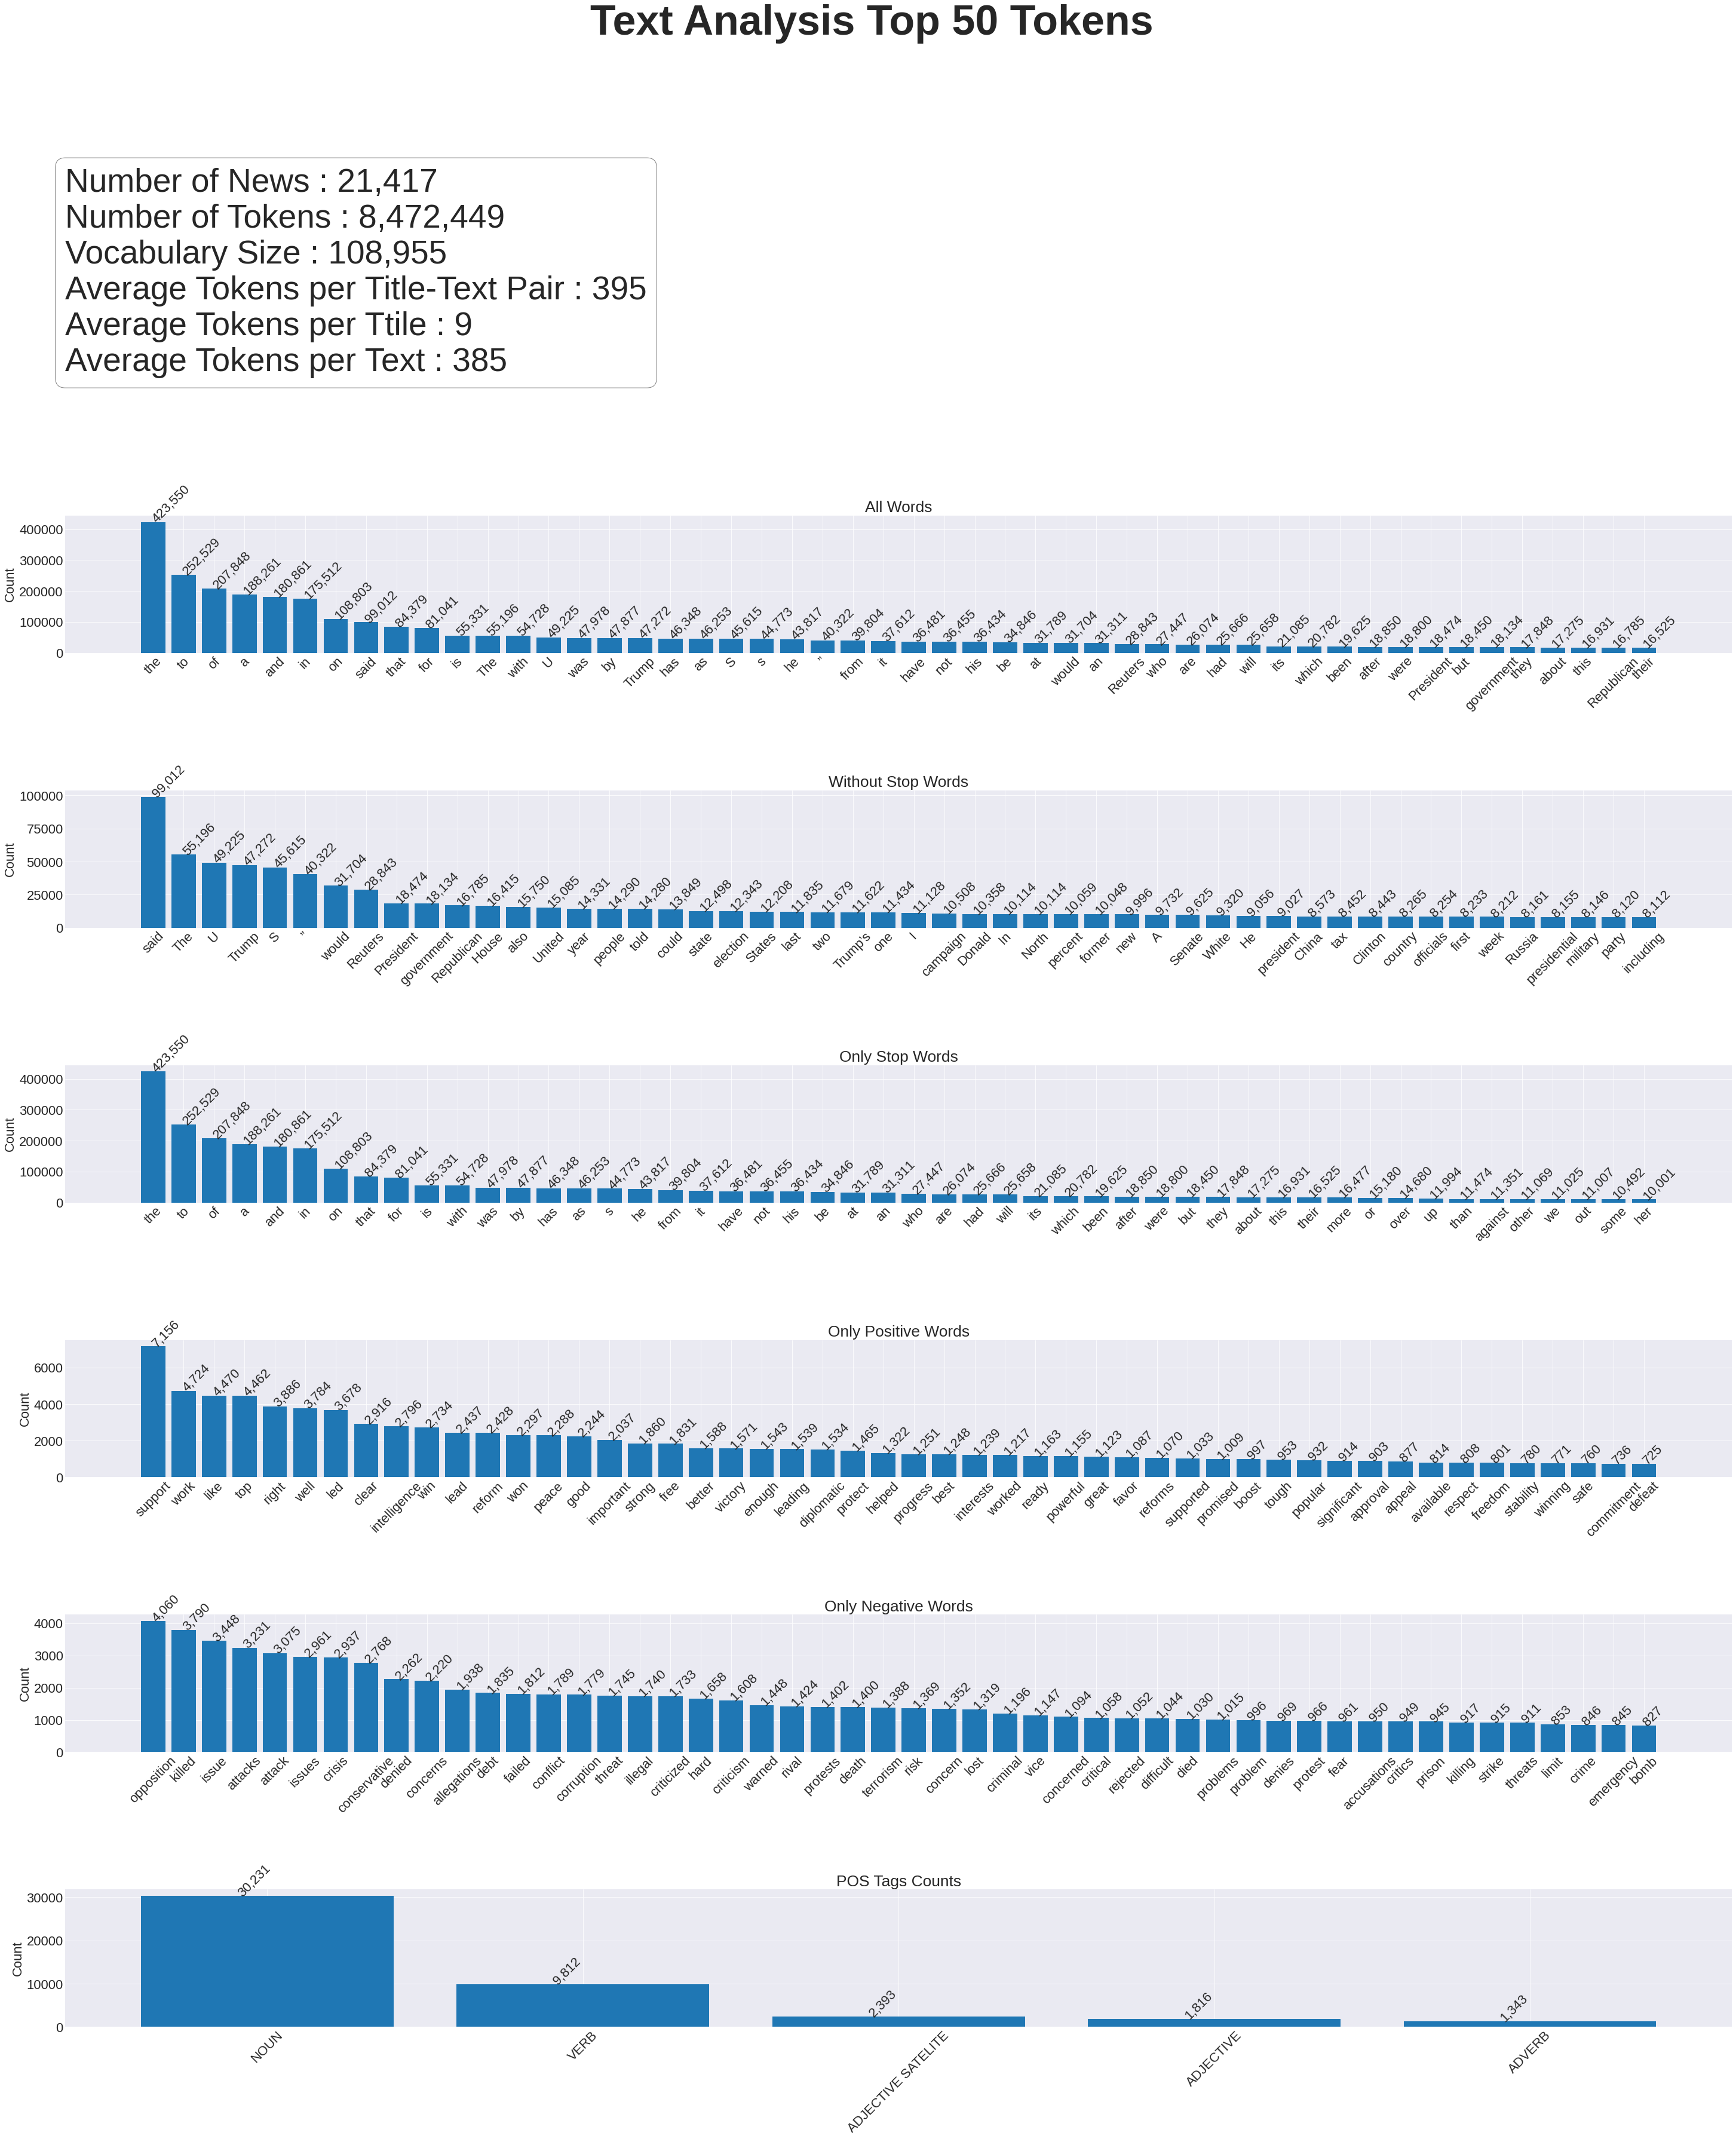

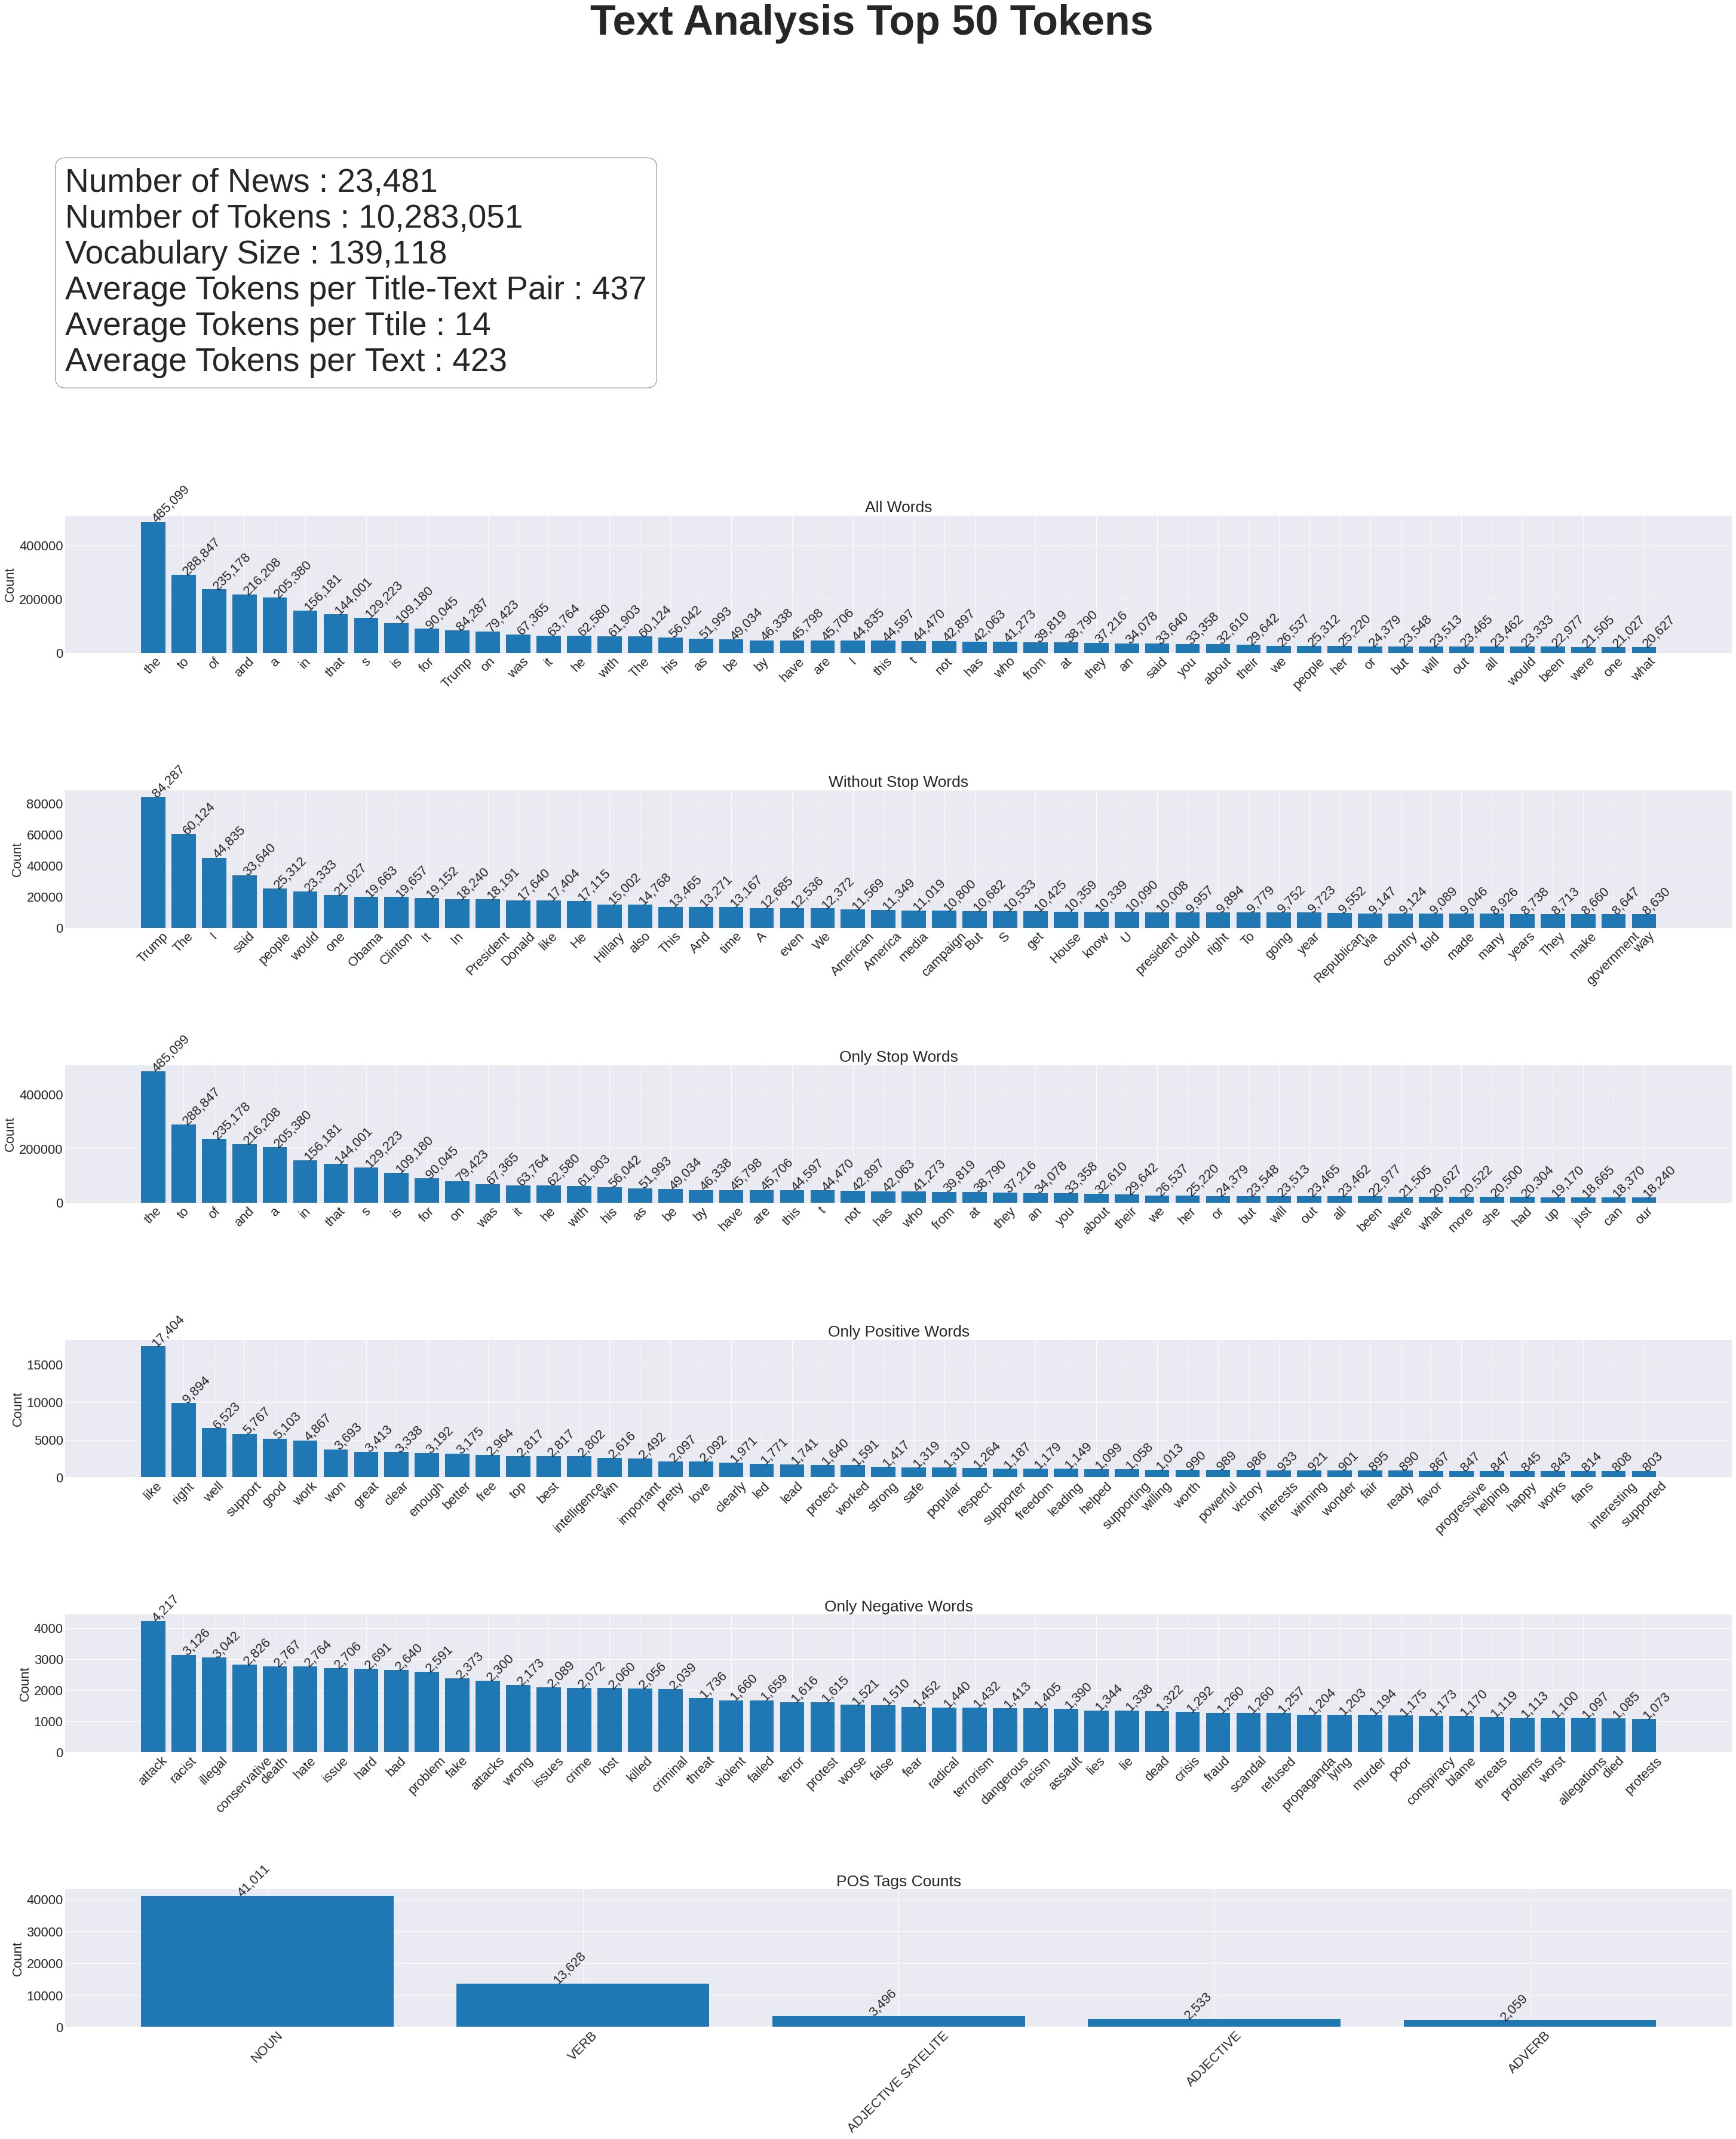

In [4]:
text_analysis_dialogues(path='/content/True.csv')
text_analysis_dialogues(path='/content/Fake.csv')

# Concatenated Data

In [16]:
fake_data_df = pd.read_csv('/content/Fake.csv')
true_data_df = pd.read_csv('/content/True.csv')

# add labels '0'-fake and '1' - true
fake_data_df['label'] = [0]*len(fake_data_df)
true_data_df['label'] = [1] * len(true_data_df)


# append both data frames
all_news = fake_data_df.append(true_data_df, ignore_index = True)

# concatenate title and text
all_news['title_text'] = ["%s %s"%(title,text) for title, text in \
                          zip(all_news['title'].values, all_news['text'].values)]

# re-arrange columsnto make them pretty
all_news = all_news[['title_text', 'title', 'text', 'subject', 'date', 'label']]

all_news.head()

,title_text,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


# Tokenize Data

In [17]:
# create tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()

# make sure all text is in correct format
print('Fixing text to make sure formatting is right...')
all_text = [fix_text(text) for text in tqdm(all_news['title_text'].values)]
all_labels = all_news['label'].values

# fit tokenizer to allt text
tokenizer.fit_on_texts(all_text)
print('Fit tokenizer to all text and titles!')

# get vocabulary size
vocab_size = len(tokenizer.word_index)

# get average length of text
indexed_all_text = tokenizer.texts_to_sequences(all_text)
avg_len = int(np.average([len(indexed_text) for indexed_text in indexed_all_text]))
print('Average text length is: %d words.' % avg_len)

# fix length all text
numpy_all_text = pad_numpy(indexed_all_text, avg_len)
print('Fixed length numpy matrix: ', numpy_all_text.shape)

Fixing text to make sure formatting is right...



Fit tokenizer to all text and titles!
Average text length is: 427 words.
Fixed length numpy matrix:  (44898, 427)


# Split Train-Test

In [18]:
text_train, text_test, labels_train, labels_test = train_test_split(numpy_all_text, all_labels, test_size=0.1, random_state=123)

# Train -Test Dataset

In [19]:
BATCH_SIZE = 32

# train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((text_train, labels_train))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE, seed=123, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE)

# test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((text_test, labels_test))
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)


# Build Model

In [21]:
model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, 16),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(1)])

model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          2153712   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 2,153,729
Trainable params: 2,153,729
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=test_dataset)

Epoch 1/2
 529/1263 [===========>..................] - ETA: 22s - loss: 0.5711 - accuracy: 0.5996

InvalidArgumentError: ignored